In [1]:
%matplotlib inline
# math libs
import math
import numpy as np
from scipy.spatial import distance
from scipy.spatial import ConvexHull

# plotting libs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random

In [2]:
def parse_points(points):
    X = [elem[0] for elem in points]
    Y = [elem[1] for elem in points]
    Z = [elem[2] for elem in points]
    return X, Y, Z

def gen_point_on_a_sphere(R=1):
    phi = random.uniform(0, 2 * math.pi)
    costheta = random.uniform(-1, 1)
    u = random.uniform(0,1)
    
    theta = math.acos(costheta)
    r = R * math.sqrt(u)
    
    x = r * math.sin(theta) * math.cos(phi)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    
    return x, y, z

### A Globally Convergent Algorithm for Facility Location on a Sphere

Let $a_1,\dots,a_m$ be $m$ points on the 3-dimensional sphere $S = \{ x \| x \in R^{3}, \lVert x \rVert = 1$, where 
$\lVert . \rVert$ is the 2-norm. Let $c_j$, $j = 1,2,\dots,m$ be given positive numbers. We want to find a point $x \in S$ that minimizes the summation of weighted geodesic distances from $x$ to all of the $m$ fiven points, i.e.,

$$ \min\limits_{x \in S} f(x) = \sum\limits_{j=1}^{m} c_j cos^{-1} (a_j^{T} x) $$

In [3]:
num_dim = 3
m = random.randint(50, 100)
a = [np.array(gen_point_on_a_sphere()) for i in range(m)]
c = [random.randint(1, 20) for i in range(m)]

print("M = ", m)

M =  76


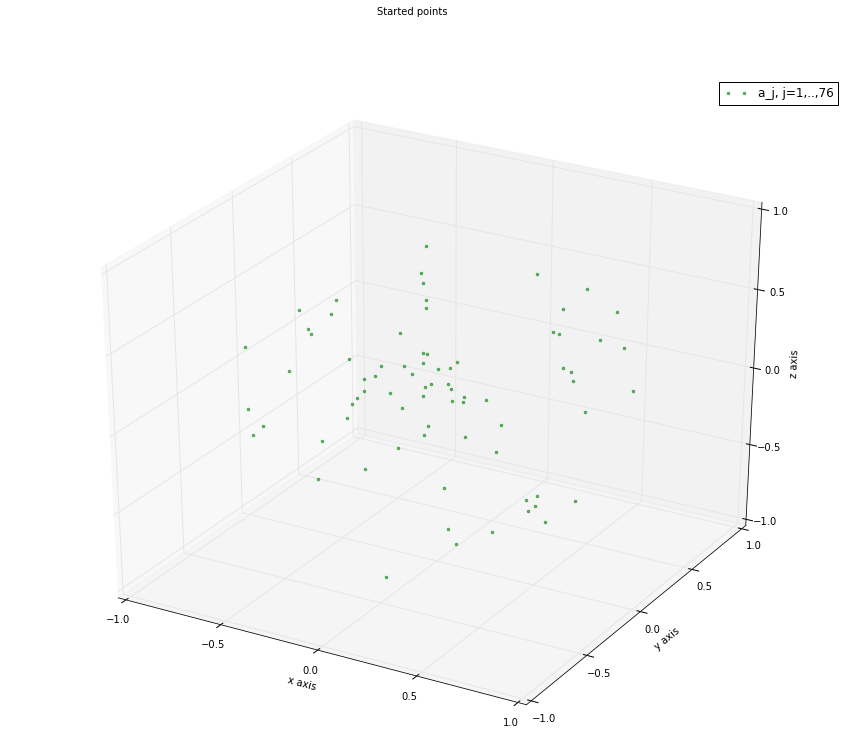

In [4]:
figure = plt.figure(figsize=(15,12))
ax = figure.gca(projection='3d')

pp = parse_points(a)
ax.plot(pp[0], pp[1], pp[2], 'g.', alpha=0.6)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
figure.suptitle('Started points')
ax.legend(['a_j, j=1,..,{}'.format(m)])

#### Algorithm

##### Step 1.

Find an existing facility $a_t$ such that $f(a_t) \le f(a_j)$ for all $j=1,2,\dots,m$. Check the optimality condition for $a_t$. If $a_t$ is an optimal solution, stop.

##### Step 2.

Let $d = - \sum\limits_{j = 1, j \neq t}^{m} c_j (a_t - a_j^{a_t}) \ \lVert a_t - a_j^{a_t} \rVert$. Find a small step size $\alpha > 0$ such that point $a_t + \alpha d$ lies in the convex hull of $a_j^{a_t}$, $j=1,2,\dots,m$ and that $x^{1} = a_t + \alpha d / \lVert a_t + \alpha d \rVert$ has a function value less than $f(a_t)$. Let $k = 1$.

##### Step 3.

Compute $a_j^{x^{k}}$ for $j=1,\dots,m$. Compute $d^{k} = - \sum\limits_{j = 1}^{m} c_j (x_k - a_j^{x^{k}}) / \lVert x_k - a_j^{x^{k}} \rVert$. If $d^{k} = 0$, stop; othervise compute 

$$ \alpha^{k} = \frac{1}{ \sum\limits_{j=1}{m} c_j / \lVert x^k - a_j^{x^k} \rVert} .$$

##### Step 4.

Set $$x^{k+1} = \frac{ x^{k} + \alpha^{k} d^{k}}{ \lVert x^{k} + \alpha^{k} d^{k} \rVert}.$$

If $f(x^{k+1}) \le f(x^{k}) - 0.1 \alpha^{k} \lVert d^{k} \rVert^{2}$, than replace $k$ with $k + 1$ and goto __Step 3__; otherwise, replace $\alpha^{k}$ with $0.5 \alpha^{k}$ and goto __Step 4__.

In [5]:
def deg(j, x):
    normalized_x = x / math.sqrt(np.dot(x, x))
    
    return a[j] / normalized_x * a[j]

In [6]:
def f(x):
    ans = 0.
    
    for j in range(m):
        ans = ans + c[j] * np.arccos(np.dot(a[j], x)) # dot - scalar product
        
    return ans

In [7]:
def F(x):
    ans = 0.
    normalized_x = x / distance.euclidean(x, np.zeros(num_dim))
    
    for j in range(m):
        ans = ans + c[j] * np.arccos(np.dot(a[j], normalized_x))
        
    return ans

In [8]:
def optimality_condition(t): 
    ans = 0.
    for j in range(m):
        if j != t:
            tmp = a[t] - (a[j] / a[t] * a[j])
            tmp = tmp / distance.euclidean(a[t], (a[j] / a[t] * a[j]))
            ans = ans + c[j] * tmp
            
    if distance.euclidean(ans, np.zeros(num_dim)) <= c[t]:
        return True
    return False

In [9]:
def D(t):
    ans = 0.
    for j in range(m):
        if j != t:
            ans = ans + c[j] * (a[t] - deg(j, a[t])) / distance.euclidean(a[t], deg(j, a[t]))
            
    return -ans

In [10]:
def D_point(point):
    ans = 0.
    for j in range(m):
        tmp = deg(j, point)
        ans = ans + c[j] * (point - deg(j, point)) / distance.euclidean(point, deg(j, point))
            
    return -ans

In [11]:
def X_in_k(x, deg):
    print(x)
    for i in range(deg):
        x *= x
    return x

In [12]:
def step_2(t, m, a):
    d = D(t)
    tmp = [deg(j, a[t]) for j in range(m)]
    x = []
    
    l, r = 0, 10
    alpha = (l + r) / 2
    
    while alpha > 1e-40:
        point = a[t] + d * alpha
        a_at = tmp
        a_at.append(point)
    
        hull = ConvexHull(a_at)
        points = np.array([np.array(a_at[index]) for index in hull.vertices])
        
        if point in points:
            x_1 = a[t] + alpha * d / distance.euclidean(a[t], - alpha * d)
            if f(x_1) < f(a[t]):
                x.append(x_1)
                break
        else:
            a_at = tmp
            r = alpha
            alpha = (l + r) / 2
            
    print(x)
    return x

In [13]:
def algorithm():
    # step 1
    t = 0
    for i in range(m):
        for j in range(m):
            if f(a[i]) <= f(a[j]):
                if optimality_condition(i):
                    return a[i]
                else:
                    t = i
                    break
    
    # step 2
    k, x = 1, step_2(t, m, a)
    
    # step 3
    xk = X_in_k(x[0], k)
    a_xk = [deg(j, xk) for j in range(m)]
    d_k = D_point(xk)
    
    alpha_k = 0.
    
    term = d_k != np.zeros(num_dim)
    while term.all():
        for j in range(m):
            alpha_k = alpha_k + 1 / (c[j] * distance.euclidean(x[k - 1], deg(j, x[k - 1])))
        
        # step 4
        tmp = x[k - 1] + alpha_k * d_k / distance.euclidean(x[k - 1], - alpha_k * d_k)
        x.append(tmp)
    
        if f(x[k - 1]) <= f(x[k - 2]) - 0.1 * alpha_k * np.dot(d_k):
            k += 1
            continue # goto step 3
        else:
            alpha_k = 0.5 * alpha_k 
            # goto step 4
        
        tmp = X_in_k(x, k)
        a_xk = [deg(j, tmp) for j in range(m)]
        d_k = D_point(tmp)
        
    return x

In [14]:
print(algorithm())

KeyboardInterrupt: 